In [1]:
import numpy as np
import h5py # getting MNIST from file
import time
import copy
from random import randint

In [2]:
MNIST_data = h5py.File('MNISTdata.hdf5', 'r')
x_train = np.float32(MNIST_data['x_train'][:])
y_train = np.int32(np.array(MNIST_data['y_train'][:,0]))
x_test = np.float32(MNIST_data['x_test'][:])
y_test = np.int32(np.array(MNIST_data['y_test'][:,0]))
MNIST_data.close()

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'MNISTdata.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
class NeuralNetwork:
    first_layer = {}
    second_layer = {}

    def __init__(self, inputs, hidden, outputs):
        # parameters and biases
        self.first_layer['para'] = np.random.randn(hidden, inputs) / np.sqrt(num_inputs)
        self.first_layer['bias'] = np.random.randn(hidden, 1) / np.sqrt(hidden)
        self.second_layer['para'] = np.random.randn(outputs,hidden) / np.sqrt(hidden)
        self.second_layer['bias'] = np.random.randn(outputs, 1) / np.sqrt(hidden)
        self.input_size = inputs
        self.hid_size = hidden
        self.output_size = outputs

    def activation_function(self, Z, type = 'ReLU', derivative = False):
        if type == 'ReLU':
            if derivative:
                return np.array([1 if i > 0 else 0 for i in np.squeeze(Z)])
            else:
                return np.array([i if i > 0 else 0 for i in np.squeeze(Z)])
        elif type == 'LeakyReLU':
            if derivative:
                return np.array([1 if i >= 0 else 0.01 for i in np.squeeze(Z)])
            else:
                return np.array([i if i >= 0 else 0.01 * i for i in np.squeeze(Z)])
        elif type == 'Sigmoid':
            if derivative:
                return 1 / (1 + np.exp(-Z)) * (1 - 1 / (1 + np.exp(-Z)))
            else:
                return 1 / (1 + np.exp(-Z))
        elif type == 'tanh':
            if derivative:
                return
            else:
                return 1 - (np.tanh(Z))**2
        else:
            raise TypeError('Invalid type!')

    def softmax(self, z):
        return 1 / sum(np.exp(z)) * np.exp(z)

    def cross_entropy_error(self, v, y):
        return -np.log(v[y])

    def forward(self, x, y):
        Z = np.matmul(self.first_layer['para'], x).reshape((self.hid_size, 1)) + self.first_layer['bias']
        print(Z)
        H = np.array(self.activation_function(Z)).reshape((self.hid_size,1))
        U = np.matmul(self.second_layer['para'],H).reshape((self.output_size,1)) + self.second_layer['bias']
        predict_list = np.squeeze(self.softmax(U))
        error = self.cross_entropy_error(predict_list,y)

        data_dict = {
            'Z':Z,
            'H':H,
            'U':U,
            'f_X':predict_list.reshape((1,self.output_size)),
            'error':error
        }
        return data_dict

    def back_propagation(self,x,y,f_result):
        E = np.array([0] * self.output_size).reshape((1, self.output_size))
        E[0][y] = 1
        dU = (-(E - f_result['f_X'])).reshape((self.output_size,1))
        db_2 = copy.copy(dU)
        dC = np.matmul(dU,f_result['H'].transpose())
        delta = np.matmul(self.second_layer['para'].transpose(),dU)
        db_1 = delta.reshape(self.hid_size,1)*self.activation_function(f_result['Z'], derivative=True).reshape(self.hid_size,1)
        dW = np.matmul(db_1.reshape((self.hid_size,1)),x.reshape((1,784)))

        grad = {
            'dC':dC,
            'db_2':db_2,
            'db_1':db_1,
            'dW':dW
        }
        return grad

    def optimize(self,b_result, learning_rate):
        # update the hyperparameters
        self.second_layer['para'] -= learning_rate * b_result['dC']
        self.second_layer['bias'] -= learning_rate * b_result['db_2']
        self.first_layer['bias'] -= learning_rate * b_result['db_1']
        self.first_layer['para'] -= learning_rate * b_result['dW']

    def loss(self,X_train,Y_train):
        # implement the loss function of the training set
        loss = 0
        for n in range(len(X_train)):
            y = Y_train[n]
            x = X_train[n][:]
            loss += self.forward(x,y)['error']
        return loss

    def train(self, X_train, Y_train, num_iterations = 1000, learning_rate = 0.5):
        # generate a random list of indices for the training set
        rand_indices = np.random.choice(len(X_train), num_iterations, replace=True)

        def calculate_learning_rate(base_rate, iter, num_iterations, schedule = False):
        # determine whether to use the learning schedule
            if schedule == True:
                return base_rate * 10 ** (-np.floor(iter / num_iterations * 5))
            else:
                return base_rate

        count = 1
        loss_dict = {}
        test_dict = {}

        for i in rand_indices:
            f_result = self.forward(X_train[i], Y_train[i])
            b_result = self.back_propagation(X_train[i], Y_train[i], f_result)
            self.optimize(b_result, calculate_learning_rate(learning_rate, i, num_iterations, True))

            if count % 1000 == 0:
                if count % 5000 == 0:
                    loss = self.loss(X_train, Y_train)
                    test = self.testing(x_test, y_test)
                    print('Trained for {} times,'.format(count), 'loss = {}, test = {}'.format(loss,test))
                    loss_dict[str(count)]=loss
                    test_dict[str(count)]=test
            count += 1

        print('Training finished')
        return loss_dict, test_dict

    def testing(self, X_test, Y_test):
        total_correct = 0
        for n in range(len(X_test)):
            y = Y_test[n]
            x = X_test[n][:]
            prediction = np.argmax(self.forward(x, y)['f_X'])
            if (prediction == y):
                total_correct += 1
        print('Accuarcy Test: ', total_correct / len(X_test))
        return total_correct / np.float32(len(X_test))

In [ ]:
num_iterations = 200000
learning_rate = 0.01
num_inputs = 28 * 28
num_outputs = 10
hidden_size = 300

In [ ]:
model = NeuralNetwork(num_inputs, hidden_size, num_outputs)
cost_dict, tests_dict = model.train(x_train, y_train, num_iterations=num_iterations, learning_rate=learning_rate)
accuracy = model.testing(x_test, y_test)

Accuarcy Test:  0.8835
Trained for 5000 times, loss = 25430.524235476565, test = 0.8835
Accuarcy Test:  0.9214
Trained for 10000 times, loss = 17688.801564868067, test = 0.9214
Accuarcy Test:  0.9178
Trained for 15000 times, loss = 16858.947375566975, test = 0.9178
Accuarcy Test:  0.9345
Trained for 20000 times, loss = 13174.432257109285, test = 0.9345
Accuarcy Test:  0.9361
Trained for 25000 times, loss = 12561.950914538085, test = 0.9361
Accuarcy Test:  0.9409
Trained for 30000 times, loss = 11053.777941735329, test = 0.9409
Accuarcy Test:  0.9495
Trained for 35000 times, loss = 9870.93163896364, test = 0.9495
Accuarcy Test:  0.9398
Trained for 40000 times, loss = 11041.723075552936, test = 0.9398
Accuarcy Test:  0.9474
Trained for 45000 times, loss = 9926.99856388303, test = 0.9474
Accuarcy Test:  0.9534
Trained for 50000 times, loss = 8317.425953488366, test = 0.9534
Accuarcy Test:  0.958
Trained for 55000 times, loss = 8052.190227961443, test = 0.958
Accuarcy Test:  0.9575
Trained

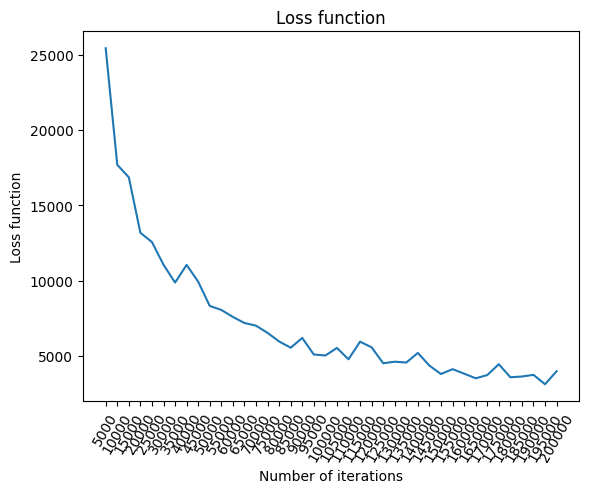

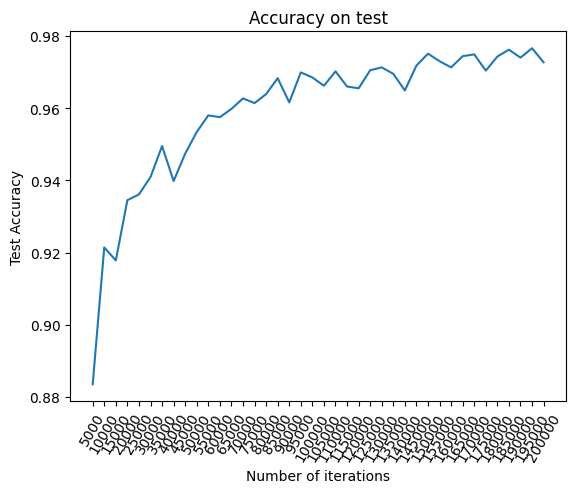

In [ ]:
import matplotlib.pyplot as plt
plt.plot(cost_dict.keys(), cost_dict.values())
plt.ylabel('Loss function')
plt.xlabel('Number of iterations')
plt.xticks(rotation = 60)
plt.title('Loss function')
plt.show()

plt.plot(tests_dict.keys(), tests_dict.values())
plt.ylabel('Test Accuracy')
plt.xlabel('Number of iterations')
plt.xticks(rotation=60)
plt.title('Accuracy on test')
plt.show()

In [ ]:
y_test[0]

7

In [ ]:
def make_prediction(model, image):
  return np.argmax(model.forward(image, 0)['f_X'])

In [ ]:
make_prediction(model, x_test[0])

7

In [ ]:
updated_first_layer = {}
updated_first_layer["para"] = model.first_layer["para"].tolist()
updated_first_layer["bias"] = model.first_layer["bias"].tolist()

In [ ]:
updated_second_layer = {}
updated_second_layer["para"] = model.second_layer["para"].tolist()
updated_second_layer["bias"] = model.second_layer["bias"].tolist()

In [ ]:
import json

In [ ]:
example = {"para" : [[1, 2, 3], [4, 5, 6], [7, 8, 9]],
           "bias" : [0, 3, 4]}
with open ('example.json', 'w') as file :
    json.dump(example, file)

In [ ]:
with open ('first_layer_para.txt', 'w') as file :
    file.write('\n'.join(['\t'.join(map(str, row)) for row in updated_first_layer["para"]]))

In [ ]:
with open ('first_layer_bias.txt', 'w') as file :
    file.write('\n'.join(['\t'.join(map(str, row)) for row in updated_first_layer["bias"]]))

In [ ]:
with open ('second_layer_para.txt', 'w') as file :
    file.write('\n'.join(['\t'.join(map(str, row)) for row in updated_second_layer["para"]]))

In [ ]:
with open ('second_layer_bias.txt', 'w') as file :
    file.write('\n'.join(['\t'.join(map(str, row)) for row in updated_second_layer["bias"]]))